# Homework 1

First name:

Last name:


---

The two exercises follow each other.

You will probably need to use an optimization library (like `Optim.jl`) and a differentiation library (`Forward.jl` or `Zygote.jl`) as well as a plotting library (`Plots.jl` or `SimplePlots.jl`) but feel free to install other libraries you might find useful.

You must send me your work before May 16th. You can send it on zulip or to `pwinant@escp.eu` with subject starting by `[eco309]`.

Don't hesitate to ask questions or help each other. Copying/pasting code is forbidden though.

---

In [1]:
using Plots

## Solow model

This model tries to explain long-term growth, its relation to productivity, population growth and the speed of convergence.

The setup is the following:

- a country accumulates capital $k_t$
- population $n_t$ grows at rate $g$ (so that $n_{t+1}=g n_t$)
- capital and labour are combined to produce $y_t = A F(k_t, n_t)$ where $A>0$ is total factor productivity.
- capital depreciates at rate $\delta \in ]0,1[$. Its law of motion is $k_{t+1}=(1-\delta)k_{t}+i_{t}$ where $i_t$ is the amount invested at time $t$
- production is either consumed or invested: $y_t = c_t + i_t$

We choose a Cobb-Douglas specification with constant returns to scale $F(k_t, n_t) = k_t^{\alpha} n_t^{1-\alpha}$.


Here we follow the Solow-Swan specification and make the simplifying assumption that there is a fixed fraction $s\in[0,1[$ of income, which is saved and invested in every period. In other words investment (or savings) is given by:

$$i_t = s y_t$$

As a result, the dynamic of capital and all other variables will be backward looking and can be simulated easily.

__Create a dictionary to hold parameter values.__

 (note: such a dictionary can be defined as `p = Dict(:a=>0.9, :b=>4)` and accessed with brackets `p[:a]` or `p[:b]`) (note2: symbols like `:a` or `:b` are lightweight string. The content must be a valid julia identifier so that it is valid to write `a=p[:a]`)

In [5]:
# We'll create a dictionary of parameters
p = Dict(
    :A=> 1.0,
    :α=>0.3, # capital share (30%)
    :β=>0.96, # (1/r): 1/1.04
    :δ=>0.1,  # depreciation rate of capital: literature
    :g=>1.0, # growth rate of population: Census
    :s=>0.2   # saving rate from national accounts (Y-C)/Y
)

Dict{Symbol, Float64} with 6 entries:
  :α => 0.3
  :A => 1.0
  :s => 0.2
  :δ => 0.1
  :g => 1.0
  :β => 0.96

__Detrend the equations of the model w.r.t. population growth. Denote the detrended variables with a hat (in the code we assume all variables are detrended and ignore the hat).__

We detrend each variable $v_t$ by population growth and denote by $\hat{v}_t = \frac{v_t}{g^t}$ the detrended variables. The detrended equations are as follows:

$$\begin{eqnarray}
\hat{k}_t & = & \hat{k}_{t-1}\frac{1-\delta}{g} + \hat{i}_{t-1} \frac{1}{g}\\
\hat{y}_t & = & A {\hat{k}_t}^{\alpha} \\
\hat{y}_t & = & \hat{c}_t + \hat{i}_t \\
\hat{i}_t & = & s \hat{y}_t
\end{eqnarray}$$

Our goal is to compute the steady-state and assess its stability.

__Compute a function `f` which returns the capital $\hat{k}_{t+1}$ as a function of $\hat{k_t}$. It is suggested to define `f(k::Float64, p::Dict{Symbol, Float64})` where `p` is a dictionary of parameters.__

In [6]:
function f(k  ; p::Dict{Symbol, Float64})
    y = p[:A]*k^(p[:α])
    i = p[:s]*y
    K = ((1-p[:δ])*k + i)/p[:g]
    return K
end

f (generic function with 1 method)

In [7]:
# test the function
f(5; p=p)

4.824131319338552

__Starting from an initial level $\hat{k}_0$ compute successive iterates of `f` to find the long-run level $\overline{k}$ of capital per capita. (Bonus: produce a nice plot of the convergence)__

In [8]:
function simulate(k0, p, T=100)
    ksim = [k0]
    for t=1:T
        k = ksim[end]
        K = f(k; p=p)
        push!(ksim, K)
    end
    return ksim
end


simulate (generic function with 2 methods)

In [12]:
sim = simulate(0.5, p, 100);

In [13]:
using Plots

In [14]:
kvec = range(0.0, 6; length=100)
fvec = f.(kvec; p);

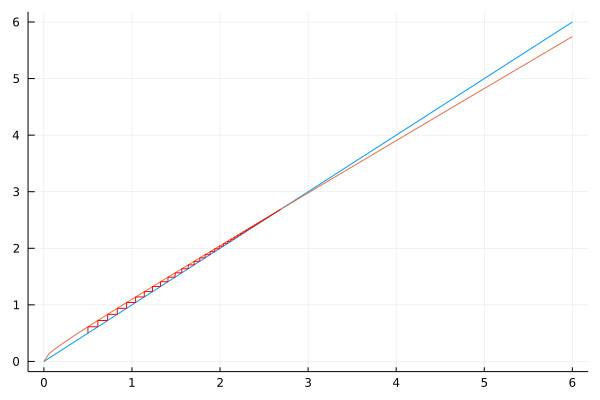

In [19]:
pl = plot(kvec, kvec)
plot!(pl, kvec, fvec)
for (a,b) in zip(sim[1:end-1], sim[2:end])
    plot!(pl, [a,b],[b,b], color=:red, legend=false)
    plot!(pl, [a,a],[a,b], color=:red, legend=false)
end
pl

__Propose and implement a way to accelerate convergence__

In [20]:
#  Aitkens' extrapolation

__What factors affect the steady-state level of capital?__

In [31]:
# let us wirte a function to compute the steady-state capital for a given calibration
function steady_state(p::Dict{Symbol, Float64}, k0=1; T=100, tol_η=1e-6)
    for t=1:T
        K = f(k0; p=p)
        if abs(K-k0)<tol_η
            return K
        end
        k0 = K
    end
    return k0
end

steady_state (generic function with 2 methods)

In [33]:
# test
steady_state(p, 1.0)

2.6904293693526475

Let us check whether population growth affects the steady-state level of capital (per capita). According to the results (below), higher population growth leads lower steady-staate, capital.

This is not surprising, if we observe that capital depreciation, is an increasing function of $g$:  $\frac{1-\delta}{g}=1-\delta-(1-\delta)\left(\frac{g-1}{g}\right)$

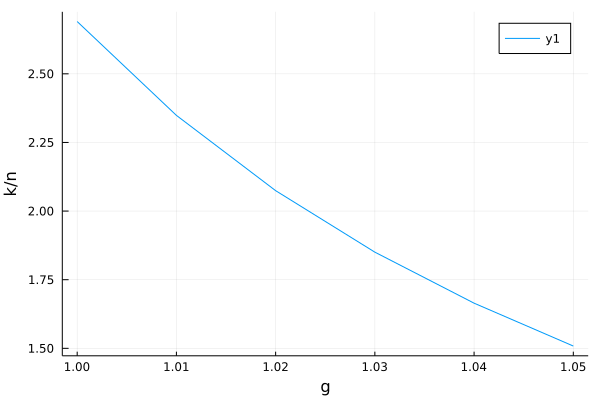

In [36]:
gvec = range(1.0, 1.05; length=6)
kbar_g = []
for g in gvec
    p0 = copy(p)
    p0[:g] = g
    kbar = steady_state(p0, 1.0)
    push!(kbar_g, kbar)
    
end
plot(gvec, kbar_g, xlabel="g", ylabel="k/n")

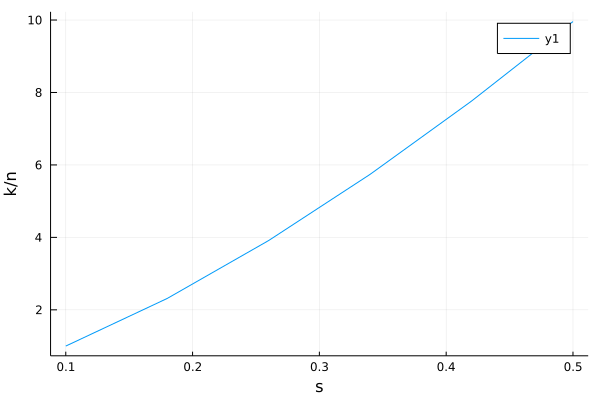

In [37]:
svec = range(0.1, 0.5; length=6)
kbar_s = []
for s in svec
    p0 = copy(p)
    p0[:s] = s
    kbar = steady_state(p0, 1.0)
    push!(kbar_s, kbar)
    
end
plot(svec, kbar_s, xlabel="s", ylabel="k/n")

__Study the stability of $f$ around $\overline{k}$ (hint: compute the right derivative). Which factors affect the speed of convergence towards the steady-state?__

You study the sequence $k_t = f(k_{t-1})$ around steady state. Define $\lambda=f^{\prime}(\overline{k}$).
Convergence is geometric with rate $\lambda$. In particular, it converges if $|\lambda|<1$


In [40]:
# we can differentiate automatically functions, whose arguments derive from Number

function f(k::Number  ; p::Dict{Symbol, Float64})
    y = p[:A]*k^(p[:α])
    i = p[:s]*y
    K = ((1-p[:δ])*k + i)/p[:g]
    return K
end

f (generic function with 2 methods)

In [41]:
using ForwardDiff

In [44]:
# stability of the steady-state
λ(p::Dict) = ForwardDiff.derivative(u->f(u;p=p), steady_state(p, 1.0))

λ (generic function with 1 method)

In [45]:
λ(p)

0.9300107005722584

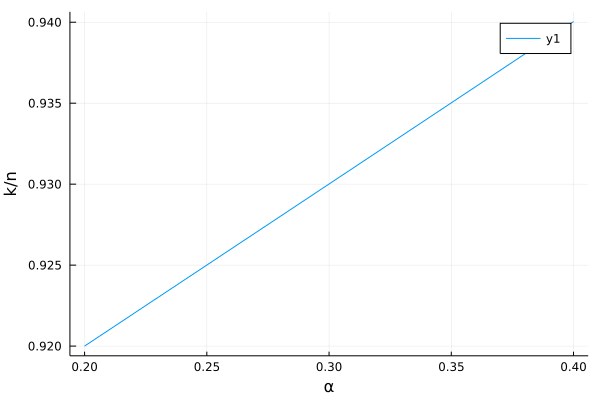

In [633]:
# how does λ depend on the saving rate ?

avec = range(0.2, 0.4; length=6)
kbar_a = []
λ_a = []
for a in avec
    p0 = copy(p)
    p0[:α] = a
    kbar = steady_state(p0, 1.0)
    lam = λ(p0)
    push!(kbar_a, kbar)
    push!(λ_a, lam)
    
end
plot(avec, λ_a, xlabel="α", ylabel="k/n")

According to the graph, we can conclude that stability is higher, when $\alpha$ is lower, that is when production function is more concave.

__Compute the steady-state directly using a Newton method and compare convergence speed.__

In [48]:
using NLsolve

In [50]:
res = NLsolve.nlsolve(u->[f(u[1];p)-u[1]], [1.0]; method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [1.0]
 * Zero: [2.6918003853316965]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

Convergence speed of Newton algorithm is quadratic. It takes 4 iterations to reach tolerance criterium of `NLSolve`.

We can keep optimization steps with `store_trace` and `extended_trace` (otherwise guesses are missing).

In [83]:
res = NLsolve.nlsolve(u->[f(u[1];p)-u[1]], [1.0]; store_trace=true, extended_trace=true, method=:newton)
values = s = [x.metadata["x"][1] for x in res.trace.states]

5-element Vector{Float64}:
 1.0
 3.499999999689021
 2.7169100663379075
 2.6918350553031805
 2.6918003853316965

Here is a plot comparing regular, geometric convergence, with the newton steps. The right panel shows absolute errors  in logs (not that gemoetric convergence is linear in log-space)

1-element Vector{Float64}:
 2.6918003853316965

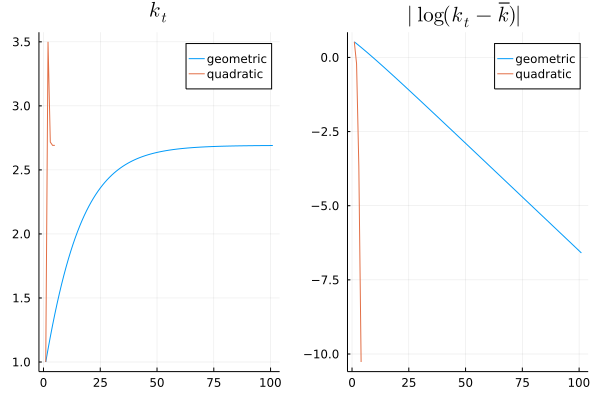

In [111]:
ss = res.zero
sim = simulate(1.0,  p, 100);

pl1 = plot(sim, label="geometric", title="\$k_t\$")
plot!(pl1, values, label="quadratic")
pl2 = plot(log.(abs.(sim.-ss)), label="geometric", title="\$|\\log(k_t-\\overline{k})|\$")
plot!(pl2, log.(abs.(values.-ss)), label="quadratic")
plot(pl1, pl2)

__Suppose one tries to maximize steady-state consumption by choosing saving rate $s$. Which value would one choose?__

First we write functions to compute steady-state and steady-state consumptions as a function of $s$.

In [112]:
function steady_state_consumption(p::Dict)
    kbar = steady_state(p)
    ybar = p[:A]*kbar^p[:α]
    ibar = p[:s]*ybar
    cbar = ybar - ibar
    return cbar
    
end

steady_state_consumption (generic function with 1 method)

In [113]:
function steady_state_consumption(s::Float64; p=Dict())
    p0 = copy(p)
    p0[:s] = s
    return steady_state_consumption(p0)
end
function steady_state(s::Float64; p=Dict())
    p0 = copy(p)
    p0[:s] = s
    return steady_state(p0, 1.0)
end

steady_state (generic function with 3 methods)

Then we consider the range $[0.1, 0.4]$ for saving rates and plot steady-state consumption as a function of $s$.

In [117]:

svec = range(0.1, 0.5; length=100);
cvec = [steady_state_consumption(e; p=p) for e in svec];
# ivec = [steady_state(e; p=p)*p[:δ]/p[:g] for e in svec];

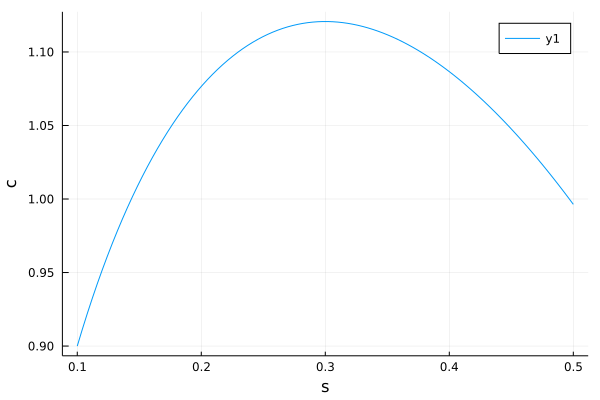

In [118]:
pl = plot(svec, cvec;xlabel="s", ylabel="c")
# plot!(pl, svec, ivec;xlabel="s", ylabel="k")

__(Bonus) Suppose an agent is given the intertemporal utility from the Ramsey–Cass–Koopmans model see exercise 2) but chooses saving rate once for all. Which saving rate would one choose to maximize intertemporal utility? Is it the same for all initial levels of capital?__



cf next exercise

## Deterministic Neoclassical Model: bruteforce

In the Ramsey–Cass–Koopmans  model (also called neoclassical growth model), a representative agent chooses $c_t$ in every period so as to maximize an intertemporal utility like $\sum_{t \geq 0} \beta^t U(c_t)$ where $\beta \in [0,1[$ is a time discount and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ is the instantaneous felicity.

The setup is exactly the same as in the the Solow model form session 3, but now we look for a time-dependent saving rule, that is a different $s_t \in [0,1[$ for each date. We will try to choose $s_t$ to maximize

$$\sum_{t = 0}^T \beta^t U(c_t) + \sum_{t = T+1}^{\infty} \beta^t U(c_T) $$


We need to choose vector $\mathbf{s} = (s_0, s_1, ... s_T)$ to maximize intertemporal utility. We can assume $\forall t>T s_t= s_T$


In this exercise, we want to define a function `objective(s::AbstractVector)` and maximize objective numerically using a numerical optimization algorithm.


__Explain why the second term is important__

Suppose we approximate the objective by $\sum_{t=0}^{T} \beta^t U(c_t)$. In the last period $T$ it is optimal to consume *everything*, i.e. $c_{T}=y_T$. This is very unrealistic, and creates a distortion which propagates to all periods before.
This distortion might be mitigated by choosing very high $T$. A better option consists in assuming $\forall t>T\; s_t = s_{T}$.
Under this assumption, the remaining term can be approximated by $ \sum_{t = T+1}^{T+K} \beta^t U(c_T)$.


__Choose an horizon $T$ and write a function `objective(s::AbstractVector, k0::Float64, T::Int, p::Dict{Symbol, Float64})` to compute the objective approximated with $T$ periods as a function of initial state `k0::Float64` and of the vector of saving rates `s::Vector` representing $(s_0, s_1, \cdots s_{T})$. Note that argument type of `s` is left unspecified to make it compatible with automatic differentiation.__

In [266]:
# we need to add $γ$ to the parameters
p = Dict(
    :A=> 1.0,
    :α=>0.3, # capital share (30%)
    :β=>0.96, # (1/r): 1/1.04
    :δ=>0.1,  # depreciation rate of capital: literature
    :g=>1.0, # growth rate of population: Census
    :γ=>4.0,
    :s=>0.21   # saving rate from national accounts (Y-C)/Y
)

Dict{Symbol, Float64} with 7 entries:
  :α => 0.3
  :γ => 4.0
  :A => 1.0
  :s => 0.21
  :δ => 0.1
  :g => 1.0
  :β => 0.96

In [267]:
steady_state(p)

2.884571450675158

Here is the implementation of the objective function. We choose, it has a few options:
- add_last_term: whether or not to approximate the remaining term
- K:  number of periods to use to approximate remaining term
- return_sim: optionally, we return the simulated levels of capital and consumption

In [274]:
function objective(s; k0=1, p=Dict(), add_last_term=false, return_sim=false, K=500)
    
    T = length(s)
    
    A = p[:A]
    α = p[:α]
    g = p[:g]
    β = p[:β]
    γ = p[:γ]
    δ = p[:δ]
    
    if return_sim
        sim=[]
    end
    
    U(x) = (x)^(1-γ)/(1-γ)

    V = 0.0
    
    for t=1:T
        y = A*k0^α
        i = s[t]*y
        c = y-i
        V += β^(t-1) * U(c)
        k1 = ((1-δ)*k0 + i)/g
        if return_sim
            push!(sim, (k0, c))
        end
        k0 = k1
    end
    
    sT = s[end]
    if add_last_term
        for t=T+1:T+K
            y = A*k0^α
            i = sT*y
            c = y-i
            V += β^t * U(c)
            k1 = ((1-δ)*k0 + i)/g
#             if return_sim
#                 push!(sim, (k0, c))
#             end
            k0 = k1
        end
    end
        

    if return_sim
        return (V,sim)
    else
        return V
    end
end

objective (generic function with 1 method)

In [277]:
# let's simulate the economy for an initial guess where savings is constantly equaly to 20% of output

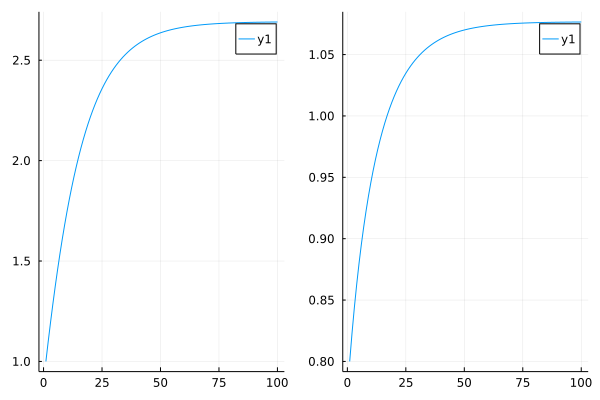

In [280]:
s0 = ones(100)* 0.2;
lower = s0*0;
upper = s0*0 .+ 1;
V0, sim0 = objective(s0; p=p, return_sim=true, add_last_term=false);
pl1 = plot([e[1] for e in sim0])
pl2 = plot( [e[2] for e in sim0])
plot(pl1, pl2)

Let'see whether we can differentiate this funciton easily.

In [282]:
using ForwardDiff

In [283]:
G  = ForwardDiff.gradient(u->objective(u; p=p), s0);

__Use library `Optim.jl` to maximize the utility function. If possible, find a way to specify exact derivatives of the objective function.__

First let's use the default call of `Optim`

In [284]:
using Optim

In [285]:
sol = optimize(u->-objective(u; p=p), s0)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     8.798326e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1384


The iteration failed. We see it uses Nelder-Mead, which doesn't use gradient information. Let's have a look at what it produced:

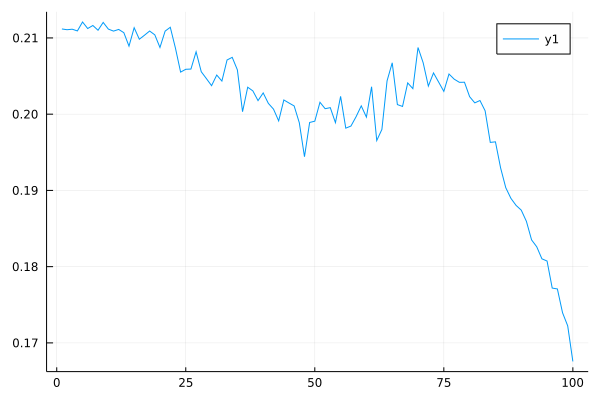

In [286]:
plot( sol.minimizer )

Let's try instead a bounded algorithm:

In [290]:
@time sol = optimize(u->-objective(u; p=p), lower, upper, s0)

  3.265049 seconds (783.68 k allocations: 18.314 MiB, 2.62% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     8.784928e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 3.00e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.05e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    3
    f(x) calls:    599
    ∇f(x) calls:   599


Default algorithm BFGS is a quasi-Newton method, which uses gradient information. it seems to have converged. We can speed it up, by providing a precise gradient.

In [294]:
@time sol = optimize(u->-objective(u; p=p), lower, upper, s0, autodiff=:forward)

  1.121015 seconds (1.76 M allocations: 100.253 MiB, 3.52% gc time, 66.24% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     8.784928e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 2.99e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.53e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.89e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    3
    f(x) calls:    623
    ∇f(x) calls:   623


Let 's look at the solution. It is smooth, but features a strange cliff at the end, coming from the fact the the optimizing agent ends up consuming the capital.

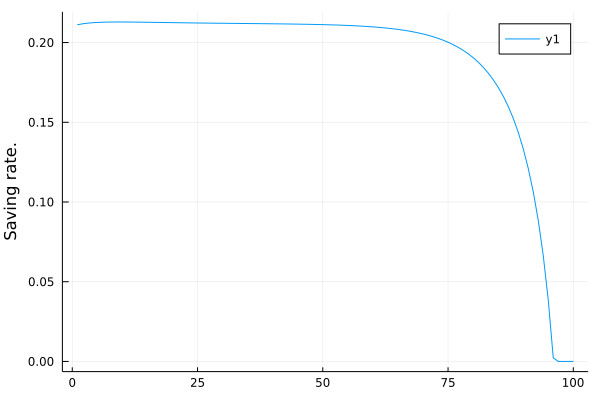

In [296]:
plot(sol.minimizer, ylabel="Saving rate.")

For this reason, we need to approximate the second part of the infinite sum (with option `add_last_term=true`)

In [298]:
@time sol = optimize(u->-objective(u; p=p, add_last_term=true), lower, upper, s0, autodiff=:forward)

  1.635289 seconds (1.75 M allocations: 99.411 MiB, 2.68% gc time, 47.89% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     8.906255e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.83e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.28e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    3
    f(x) calls:    297
    ∇f(x) calls:   297


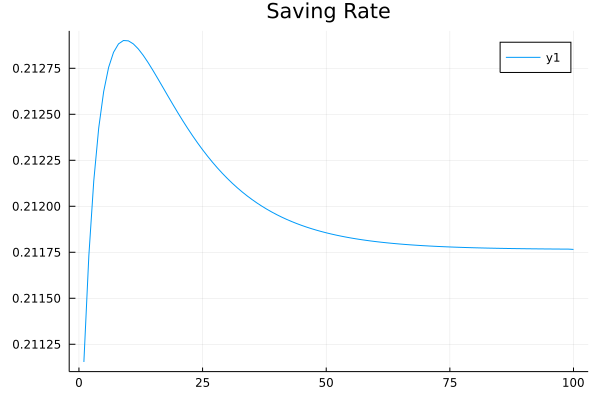

In [300]:
plot(sol.minimizer, title="Saving Rate")

In [ ]:
We see now that saving rates converge nicely to a constant after some initial (small) variations.